# HW4: Mapping & Localization

## EECE 5550: Mobile Robotics (Spring 2024)

**Collaboration Statement:**

In [ ]:
# Fill this in per the syllabus, or we will assign a zero to this assignment.
#sirigiri Vasu Kumar Reddy


# Installation

This semester, we will use a custom simulator, called `gym-neu-racing`, to develop navigation algorithms. We implemented the basic structure of this simulator for you, and the HW assignments will ask you to implement important functions (e.g., kinematics, sensing, planning, mapping).

To install the simulator, you can use this command (it will download the latest code from GitLab and automatically install it in the environment your Colab notebook runs in):

In [1]:
!pip install git+https://gitlab.com/neu-autonomy/gym-neu-racing.git@hw4

  Cloning https://gitlab.com/neu-autonomy/gym-neu-racing.git (to revision hw4) to /tmp/pip-req-build-hlhz3w0y
  Running command git clone --filter=blob:none --quiet https://gitlab.com/neu-autonomy/gym-neu-racing.git /tmp/pip-req-build-hlhz3w0y
  Running command git checkout -b hw4 --track origin/hw4
  Switched to a new branch 'hw4'
  Branch 'hw4' set up to track remote branch 'hw4' from 'origin'.
  Resolved https://gitlab.com/neu-autonomy/gym-neu-racing.git to commit 895b1589bc8b7d4a9ae65b109a485081583ee5cd
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.5/12.5 MB 26.5 MB/s eta 0:00:00
  Created wheel for gym-neu-racing: filename=gym_neu_racing-0.0.1-py3-none-any.whl size=66881 sha256=9dc7db3a7e71c5a49325e7081454e8d74bbbf6ab6405ce02ac0e8ff2492cd5ff
  Stored in directory: /tmp/pip-ephem-wheel-cache-9jj8uwka/wheels/58/0e/5d/d48d3ec66d1aa09b03520c684cb531c83b84589fe5

Now that the simulator and its dependencies have been installed, you can import the modules you'll need for this assignment:

In [2]:
import gymnasium
import numpy as np
import gym_neu_racing
from gymnasium import spaces
from gym_neu_racing.envs.wrappers import StateFeedbackWrapper, MappingWrapper
import matplotlib.pyplot as plt
from typing import Callable
import matplotlib.cm as cmx
import matplotlib.colors as colors
from gym_neu_racing import motion_models
from gym_neu_racing import sensor_models
from gym_neu_racing.sensor_models.sensor_model import SensorModel
from gym_neu_racing.envs.map import Map
from skimage.draw import line
from gym_neu_racing.sensor_models import Lidar2D
from scipy.linalg import expm

You can create an instance of the simulator that you'll build on throughout the assignment:

# Problem 1: Localization (estimating robot pose in a known map)

## 1a) Particle Filter: Propagation Step

In localization, your job is to estimate the robot's pose over time given sensor data and control inputs. This problem will have you implement a particle filter, which is a powerful approximation of the Bayes filter for systems with highly nonlinear motion/measurement models. We'll assume a differential drive robot (which has a left and right wheel, each of radius $r$ m, spaced $w$ m apart).

To initialize the particle filter, you should create a number of particles at the origin with zero rotation. In particular, you should represent these particles as transformation matrices, i.e., elements of $SE(2)$, so every particle can start at $I_{3 \times 3}$.

For this first part, you can focus on the propagation step. At each propagation step, you'll get a left and right wheel angular speed measurement in rad/s, which you should use to update `self.particles` using the motion model.

The state propagation step of the particle filter requires a procedure for sampling from the motion model $p(x_{t+1} | x_t, u_t)$.  Recall from our lecture on robot modeling that differential drive robots are actuated by controlling the velocities $(\dot{\varphi}_l, \dot{\varphi}_r)$ of their left and right wheel speeds.

Suppose that we can only control the wheel speeds of our robot imprecisely; that is, the *true* left and right wheel speeds $(\tilde{\varphi}_l, \tilde{\varphi}_r)$ are related to the *measured* wheel speeds $u \triangleq  (\dot{\varphi}_l, \dot{\varphi}_r)$ according to:

$$
\tilde{\varphi}_l = \dot{\varphi}_l + \epsilon_l, \quad \epsilon_l \sim N(0, \sigma_l^2) \\
\tilde{\varphi}_r = \dot{\varphi}_r + \epsilon_r, \quad \epsilon_r \sim N(0, \sigma_r^2)
$$

Using these expressions, you should come up with a generative description (i.e., a list of steps that provide you with samples from) for the motion model $p(x_{t_2} | x_{t_1}, \dot{\varphi}_l, \dot{\varphi}_r, r, w, \sigma_l, \sigma_r)$ that parameterizes the distribution of the pose of the robot $x_{t_2} \in SE(2)$ at time $t_2$ as a function of its pose $x_{t_1} \in SE(2)$ at time $t_1$ given the *measured* wheel speeds $(\dot{\varphi}_l, \dot{\varphi}_r)$, its wheel radius $r$ and track width $w$, and the variances $\sigma_l$ and $\sigma_r$ for the true wheel speeds.

For the noiseless case, we have derived the following expressions for you. Your job is to extend these to the noisy case above. The robot's velocity, $\dot{\Omega}$, at $I \in SE(2)$ as a function of the wheel speeds is
$$
\dot{\Omega} \colon R^2 \to Lie(SE(2)) \\
\dot{\Omega}(\dot{\varphi}_l, \dot{\varphi}_r) =
\begin{pmatrix}
0 & -\frac{r}{w}(\dot{\varphi}_r - \dot{\varphi}_l) & \frac{r}{2}(\dot{\varphi}_r + \dot{\varphi}_l) \\
\frac{r}{w}(\dot{\varphi}_r - \dot{\varphi}_l) & 0 & 0 \\
0 & 0 & 0
\end{pmatrix},
$$
and the robot's trajectory $X(t)$ is the *integral curve* that starts at the pose $X_0 \in SE(2)$ at time $t = 0$,
$$
X(t) = X_0 \exp\left(t\dot{\Omega}(\dot{\varphi}_l, \dot{\varphi}_r)\right).
$$
Note that this $\exp$ is the matrix exponential (e.g., `scipy.linalg.expm`).

**Deliverables**:
- Implement the `ParticleFilter.step` method with the particle filter propagation step for a differential-drive ground robot.  Your function will take in the measured wheel speeds, `wheel_speeds`=$(\dot{\varphi}_l, \dot{\varphi}_r)$, and use the parameters `self.dt`, `self.r`, `self.w`, `self.sigma_l`, and `self.sigma_r` to update `self.particles` from a particle set $X_{t} = \lbrace x_{t}^{[i]} \rbrace_{i = 1}^n \subset SE(2)$ describing the robot's belief over its position at time $t$ to a particle set $X_{t+dt} = \lbrace x_{t+dt}^{[i]} \rbrace_{i = 1}^n \subset SE(2)$ describing the robot's belief over its pose at time $t+dt$, sampled according to the generative model provided above.
- Provide a plot with the position of your particles after each propagation step and the resulting position estimate (mean of all of your particle positions).

In [46]:
class ParticleFilter:
    def __init__(
        self,
        map=None,
        num_particles=5,
        sigma_l=0.05,
        sigma_r=0.05,
        sigma_p=0.10,
        r=0.25,
        w=0.5,
        dt=0.1,
    ):
        self.num_particles = num_particles
        self.sigma_l = sigma_l
        self.sigma_r = sigma_r
        self.sigma_p = sigma_p
        self.r = r
        self.w = w
        self.dt = dt
        self.map = map

        self.particles = np.tile(np.eye(3), (num_particles, 1, 1))
        self.t = 0
        self.x0 = self.particles.copy()

        self.sigma_inv = np.linalg.inv(
            np.diag([self.sigma_p**2, self.sigma_p**2])
        )

    def get_pos_mean_and_cov(self) -> tuple[np.ndarray, np.ndarray]:
        """Extract mean/cov of position over all particles."""
        positions = self.particles[:, 0:2, 2]
        pos_mean = np.mean(positions, axis=0)
        pos_cov = np.cov(positions[:, 0], positions[:, 1])
        return pos_mean, pos_cov

    def step(self, obs: dict) -> np.ndarray:
        propagated_particles = self.propagate(obs["wheel_speeds"])
        updated_particles = self.update(propagated_particles)
        return updated_particles

    def propagate(self, wheel_speeds):
        """Propagate particles forward on a motion model."""

        for i in range(self.num_particles):
            v_l = wheel_speeds[0] + np.random.normal(0, self.sigma_l)
            v_r = wheel_speeds[1] + np.random.normal(0, self.sigma_r)
            omega_l = v_l / self.r

            omega_r = v_r / self.r
            omega = (self.r / self.w) * (omega_r - omega_l)
            v = (self.r / 2) * (omega_r + omega_l)


            motion_model = np.array([
                [0, -omega, v * np.cos(self.particles[i, 0, 2])],
                [omega, 0, v * np.sin(self.particles[i, 0, 2])],
                [0, 0, 0]
            ])

            self.particles[i] = np.dot(expm(self.dt * motion_model), self.particles[i])

        return self.particles.copy()

    def update(self, observation) -> np.ndarray:
        """Re-sample particles based on an incoming measurement."""
        weights = np.exp(-0.5 * np.sum((self.particles[:, :2, 2] - observation)**2 / self.sigma_p**2, axis=1))
        weights /= np.sum(weights)

        indices = np.random.choice(np.arange(self.num_particles), size=self.num_particles, replace=True, p=weights)
        self.particles = self.particles[indices]
        return self.particles.copy()

The following code will enable you to test your particle filter for *dead reckoning*, which is the process of propagating your motion model/odometry without using any external measurement (e.g., lidar, GPS, camera). By default, the robot will start at the origin, and drive at a constant $(v_x, \omega)$, so its true state should trace out a circle. But, since your particle filter accounts for potential noise in each wheel speed measurement, the uncertainty in your state estimate (i.e., belief of the robot's pose) will grow.

Time: 0.0
Position Estimate Mean:
 [-1.39133435  1.62195208]
Position Estimate Covariance:
 [[ 0.3398634  -0.28073596]
 [-0.28073596  1.64042753]]
--
Time: 5.0
Position Estimate Mean:
 [2.1403976  2.66634372]
Position Estimate Covariance:
 [[ 7.40645344 -0.53208967]
 [-0.53208967  2.10410043]]
--
Time: 10.0
Position Estimate Mean:
 [ 2.14487555 -0.63557964]
Position Estimate Covariance:
 [[ 8.87798688  0.38651447]
 [ 0.38651447 12.78766281]]
--
Time: 15.0
Position Estimate Mean:
 [-0.12780767 -1.66623869]
Position Estimate Covariance:
 [[14.25231987 -0.19967748]
 [-0.19967748 11.63822513]]
--


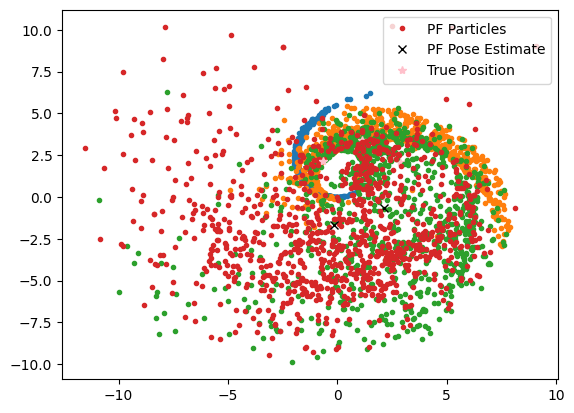

In [47]:
def run_dead_reckoning(env, robot_radius, robot_wheel_spacing, action, num_particles, dt):

    # wheel speed sensor is only sensor that simulator should model here
    env.unwrapped.sensor_models = {
        "wheel_speeds": sensor_models.WheelSpeedSensor(
            r=robot_radius, w=robot_wheel_spacing
        ),
    }
    env.unwrapped.dt = dt

    # set up environment
    np.random.seed(0)
    obs, _ = env.reset()
    env.unwrapped.state = np.array([0.0, 0.0, 0.0])
    env.unwrapped.action = action
    obs = env.unwrapped._get_obs()  # pylint:disable=protected-access

    localizer = ParticleFilter(
        dt=dt,
        num_particles=num_particles,
        r=robot_radius,
        w=robot_wheel_spacing,
    )

    for t in np.arange(start=0, stop=20., step=dt):

        # propagate particles every dt seconds using wheel speed measurements
        localizer.propagate(obs["wheel_speeds"])
        pos_mean, pos_cov = localizer.get_pos_mean_and_cov()
        obs, _, _, _, _ = env.step(action)

        # visualize positions of particles every dt seconds
        particles = localizer.particles.copy()
        plt.plot(particles[:, 0, 2], particles[:, 1, 2], ".", label="PF Particles")
        plt.plot(pos_mean[0], pos_mean[1], "x", c="k", label="PF Pose Estimate")
        plt.plot(
          env.unwrapped.state[0], env.unwrapped.state[1], "*", c="pink", label="True Position"
        )

        print(f"Time: {t}")
        print(f"Position Estimate Mean:\n {pos_mean}")
        print(f"Position Estimate Covariance:\n {pos_cov}")
        print("--")

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.show()

env = gymnasium.make("gym_neu_racing/NEUEmptyWorld-v0")
robot_radius = 0.25
robot_wheel_spacing = 0.5
action = np.array([0.4375, 0.25])
num_particles = 1000
dt = 5.0
run_dead_reckoning(env, robot_radius, robot_wheel_spacing, action, num_particles, dt)

## 1b) Particle Filter: GPS Measurement Updates

Similarly, the measurement update step of the particle filter requires a procedure for evaluating the measurement likelihood function $p(z_t | x_t)$.

Suppose that our robot is equipped with a sensor that is capable of producing a noisy measurements of its position in the plane (for example, a GPS receiver).  Specifically, the measurement $z_t \in R^2$ at time $t$ is related to the robot's pose $x_t \triangleq (l_t, R_t) \in SE(2)$ at time $t$ according to:

$$
z_t = l_t + \epsilon_p, \quad \epsilon_p \sim N(0, \sigma_p^2 I_2).
$$

In this part, you will first derive a closed-form expression (i.e., PDF) for the measurement likelihood function $p(z_t | x_t)$ under this measurement model. Then, you will use this PDF to write a function that implements the particle filter update step.

To make this somewhat realistic, you should propagate your particles using wheel speed measurements every 0.1 seconds and you should update your particles using GPS measurements every 5 seconds. We provide you with function `run_particle_filter_with_gps` to implement this timing.

**Deliverables**:
- Implement the `ParticleFilter.update` method above to incorporate position measurements (e.g., from a noisy GPS reading). Your function should accept as input a noisy position $z_t$ measurement sampled according to the generative model, and can use the magnitude $\sigma_p$ of the measurement noise (`self.sigma_p`) to update the `self.particles` from the particle set $X_{t} = \lbrace x_{t}^{[i]} \rbrace_{i = 1}^n \subset SE(2)$ representing its prior belief over its pose to the particle set $\bar{X}_{t} = \lbrace x_{t}^{[i]} \rbrace_{i = 1}^n \subset SE(2)$ modeling the robot's *posterior* belief after incorporating the measurement $z_t$.
- Provide a plot with the position of your particles after each GPS measurement update, along with the GPS measurement itself and the resulting position estimate (mean of all of your particle positions).

Time: 5.0
Position Estimate Mean: [1.18832854 1.21215325]
Position Estimate Covariance: [[ 0.003276   -0.00419987]
 [-0.00419987  0.01342488]]
--
Time: 10.0
Position Estimate Mean: [0.55075282 2.92382017]
Position Estimate Covariance: [[ 0.006036   -0.00366536]
 [-0.00366536  0.00421559]]
--
Time: 15.0
Position Estimate Mean: [-0.55062886  2.98744184]
Position Estimate Covariance: [[0.001119   0.00050838]
 [0.00050838 0.00323713]]
--
Time: 20.0
Position Estimate Mean: [-1.46860752  1.47238154]
Position Estimate Covariance: [[0.00496223 0.00035097]
 [0.00035097 0.0153088 ]]
--


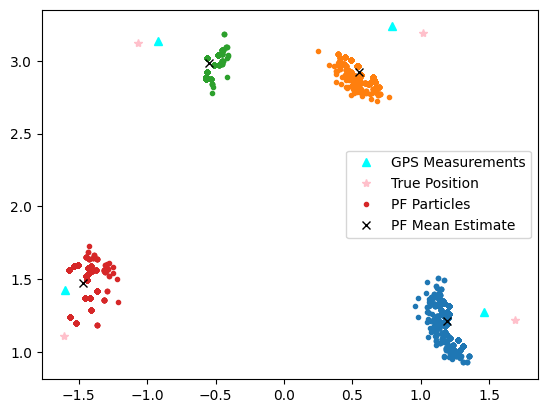

In [48]:
def run_particle_filter_with_gps(env, robot_radius, robot_wheel_spacing, action, num_particles, dt, gps_freq):

    # simulator should model a wheel speed sensor and GPS at each timestep
    env.unwrapped.sensor_models = {
        "wheel_speeds": sensor_models.WheelSpeedSensor(
            r=robot_radius, w=robot_wheel_spacing
        ),
        "gps": sensor_models.GPS(gps_variance=0.5**2),
    }
    env.unwrapped.dt = dt

    # initialize the system at the origin
    np.random.seed(0)
    obs, _ = env.reset()
    env.unwrapped.state = np.array([0.0, 0.0, 0.0])
    env.unwrapped.action = action
    obs = env.unwrapped._get_obs()  # pylint:disable=protected-access

    localizer = ParticleFilter(
        dt=dt,
        num_particles=num_particles,
        r=robot_radius,
        w=robot_wheel_spacing,
    )

    for t in np.arange(start=0, stop=20.1, step=dt):
        obs, _, _, _, _ = env.step(action)

        # propagate the particles every dt seconds with the current wheel speeds
        localizer.propagate(obs["wheel_speeds"])

        # update the particles every gps_freq seconds with the current GPS measurement
        if (t % gps_freq < 0.01 or t % gps_freq > gps_freq - 0.01) and t > 0:
            localizer.update(obs["gps"])
            plt.plot(obs["gps"][0], obs["gps"][1], "^", c="cyan", label="GPS Measurements")
            plt.plot(
                env.unwrapped.state[0], env.unwrapped.state[1], "*", c="pink", label="True Position"
            )

            particles = localizer.particles
            pos_mean, pos_cov = localizer.get_pos_mean_and_cov()
            obs, _, _, _, _ = env.step(action)

            plt.plot(
                particles[:, 0, 2],
                particles[:, 1, 2],
                ".",
                zorder=0,
                label="PF Particles"
            )
            plt.plot(pos_mean[0], pos_mean[1], "x", c="k", label="PF Mean Estimate")

            print(f"Time: {t}")
            print(f"Position Estimate Mean: {pos_mean}")
            print(f"Position Estimate Covariance: {pos_cov}")
            print("--")

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys())
    plt.show()

env = gymnasium.make("gym_neu_racing/NEUEmptyWorld-v0")
robot_radius = 0.25
robot_wheel_spacing = 0.5
action = np.array([0.4375, 0.25])
num_particles = 1000
dt = 0.1
gps_freq = 5. # seconds between gps measurements
run_particle_filter_with_gps(env, robot_radius, robot_wheel_spacing, action, num_particles, dt, gps_freq)

## 1c) Monte Carlo Localization (Particle Filter with Lidar Measurement Updates)

While GPS measurements provide fairly direct information about the robot's current pose, GPS is not available in many applications (e.g., underground, underwater, on Mars). Therefore, in this part you'll extend your particle filter to incorporate lidar measurements and a known prior map. You can assume the map of the world is static (not changing over time).

You can build on your ParticleFilter without re-writing the whole thing. Instead, you can work on `MCL`, a subclass of `ParticleFilter`, which overrides the `initialize_particles` and `update` methods.

In `initialize_particles`, you could randomly distribute particles throughout the free space in the map, or other ideas to you come up with to get sufficient particle diversity.

In `update`, you will weigh and re-sample the particles based on the latest lidar measurement and your map. One possible way to do this could be to query  `self.lidar_model.step([x,y,theta], None)` to get the *ideal* lidar reading from a particular particle, then estimate a likelihood of receiving the ranges you actually got (e.g., treating each beam's range as an independent random variable, each one sampled from a Gaussian centered at that beam's ideal range with some variance you can pick, `self.sigma_r`).

Similar to 1b, you should propagate your `wheel_speeds` every 0.1 seconds and update your particles with a lidar measurement every 1 second.

**Deliverables**:
- Implement `MCL` to estimate the robot's state in the map using the wheel speed sensor measurements, lidar measurements, and knowledge of the true environment map.
- Plot your particles at a few important timesteps to show that your algorithm  provides a meaningful estimate of the robot's true state

In [52]:
class MCL(ParticleFilter):
    def __init__(
        self,
        map=None,
        num_particles=5,
        sigma_l=0.05,
        sigma_r=0.05,
        sigma_lidar=0.10,
        r=0.25,
        w=0.5,
        dt=0.1,
    ):
        super().__init__(
            num_particles=num_particles,
            sigma_l=sigma_l,
            sigma_r=sigma_r,
            r=r,
            w=w,
            dt=dt,
        )

        self.sigma_lidar = sigma_lidar
        self.map = map

        self.initialize_particles()
        self.x0 = self.particles.copy()

        self.lidar_model = Lidar2D(map)

    def initialize_particles(self) -> None:

        # for example...
        # - uniformly randomly sample (x,y) within [[-self.map.x_width / 2, -self.map.y_width / 2], [self.map.x_width / 2, self.map.y_width / 2]]
        # - transform (x,y) point into map indices using self.map.world_coordinates_to_map_indices
        # - check if that cell is free using self.map.static_map[...]
        # - if free, randomly sample a heading angle theta
        # - populate the SE(2) matrix corresponding to that (x, y, theta)
        # - add that SE(2) matrix to self.particles
        # --> self.particles should be a np array of shape (num_particles, 3, 3) after this function is done
        self.particles = np.zeros((self.num_particles, 3, 3))
        map_x_resolution = np.arange(-self.map.x_width / 2, self.map.x_width / 2, 0.01)
        map_y_resolution = np.arange(-self.map.y_width / 2, self.map.y_width / 2, 0.01)

        for i in range(self.num_particles):
            while True:
                x = np.random.choice(map_x_resolution)
                y = np.random.choice(map_y_resolution)
                map_indices, _ = self.map.world_coordinates_to_map_indices(np.array([[x, y]]))
                map_x, map_y = map_indices[0]

                if self.map.static_map[map_x, map_y] == 0:
                    break

            theta = np.random.uniform(0, 2 * np.pi)  # Randomly sample a heading angle
            particle = np.array([
                [np.cos(theta), -np.sin(theta), x],
                [np.sin(theta), np.cos(theta), y],
                [0, 0, 1]
            ])
            self.particles[i] = particle
        # print(f"after: {self.particles}")
        return self.particles.copy()

    def update(self, observation) -> np.ndarray:
        """Re-sample particles based on an incoming measurement."""

        weights = []

        for i in range(self.num_particles):
            x, y = self.particles[i, 0:2, 2]
            theta = np.arctan2(self.particles[i, 1, 0], self.particles[i, 0, 0])
            ideal_lidar_reading = self.lidar_model.step([x, y, theta], None)

            error = ideal_lidar_reading["ranges"] - observation["ranges"]
            weight = np.exp(-0.5 * np.sum((error)**2 / self.sigma_lidar**2))

            weights.append(weight)
        weights = np.array(weights)

        weights /= (np.sum(weights))
        indices = np.random.choice(np.arange(self.num_particles), size=self.num_particles, replace=True, p=weights)
        self.particles = self.particles[indices]
        return self.particles.copy()

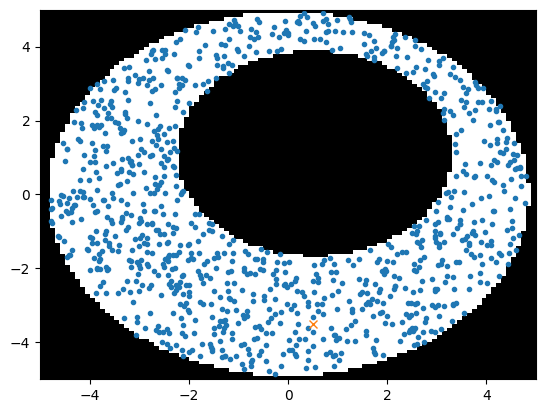

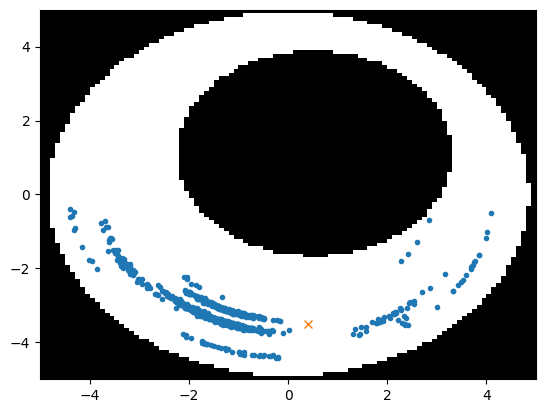

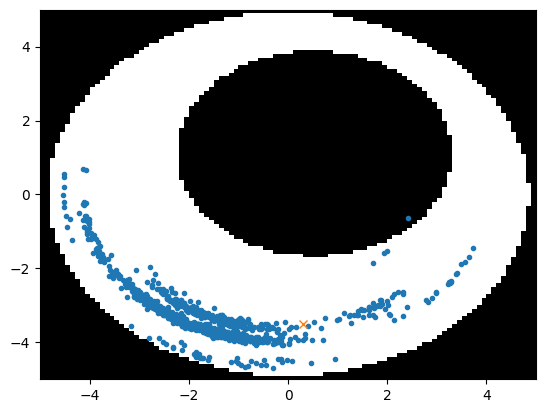

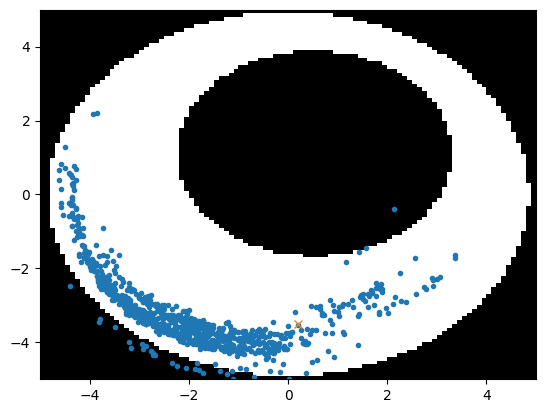

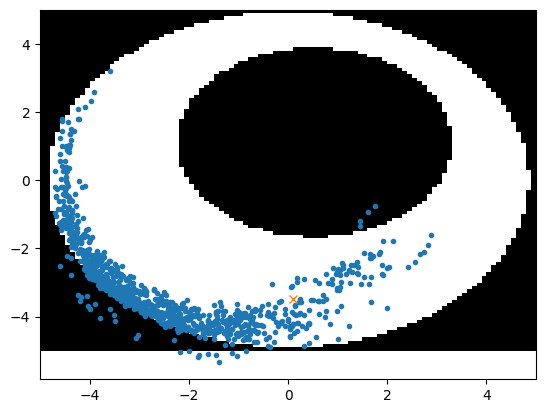

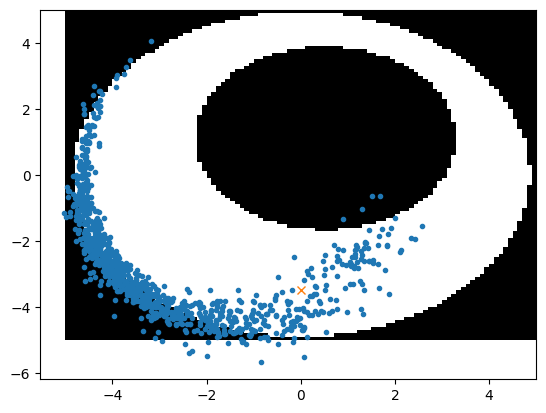

lap completed!
clockwise -> fwd lap completed


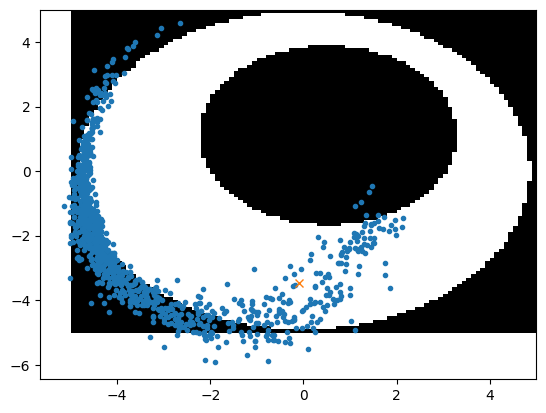

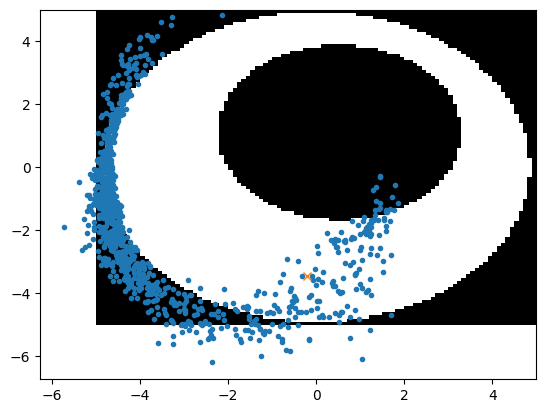

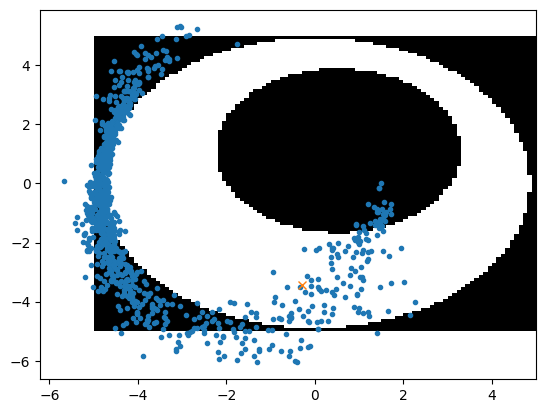

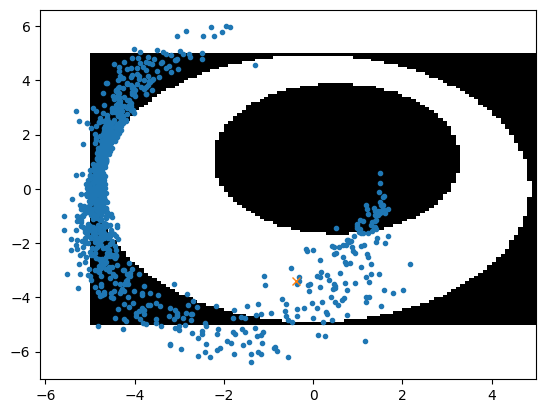

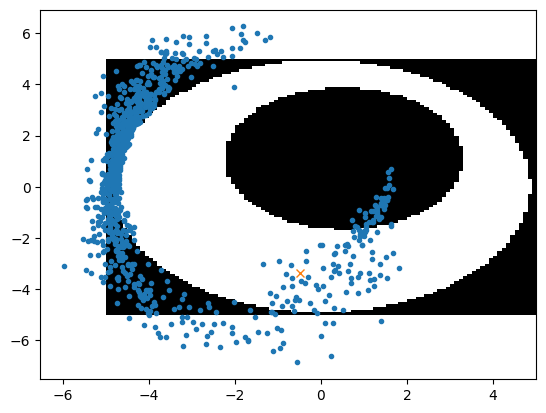

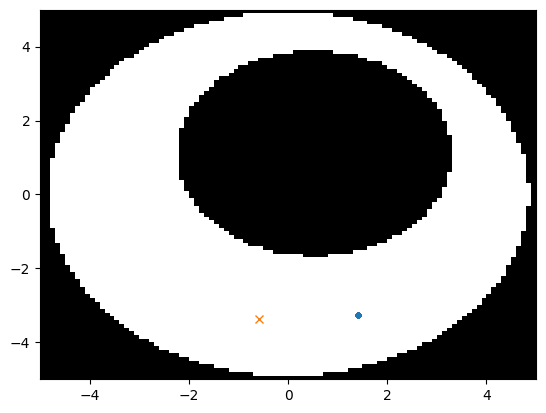

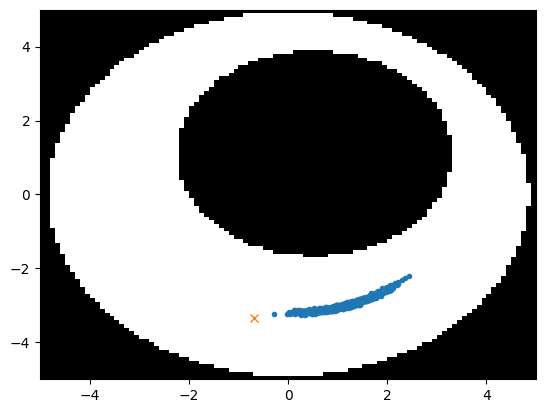

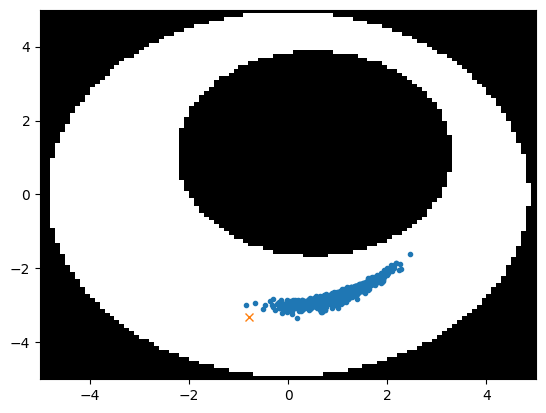

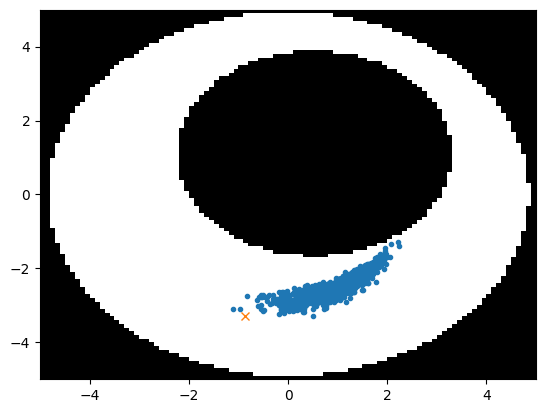

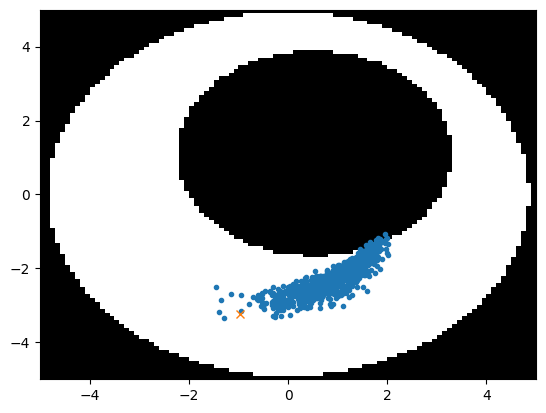

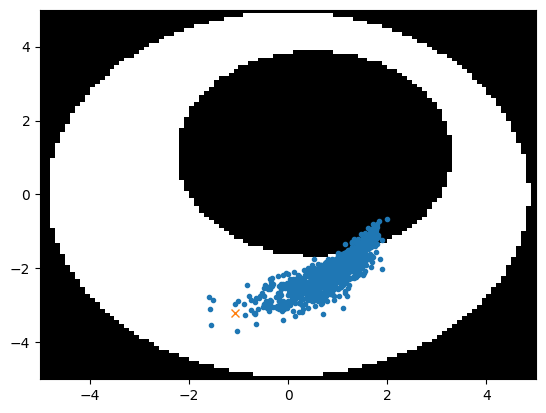

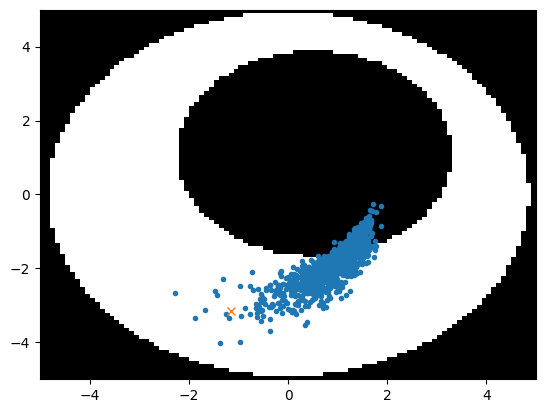

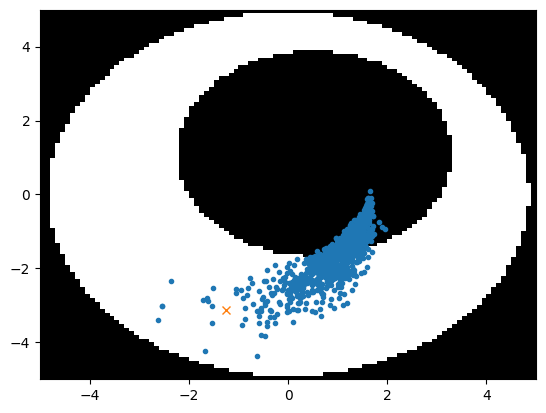

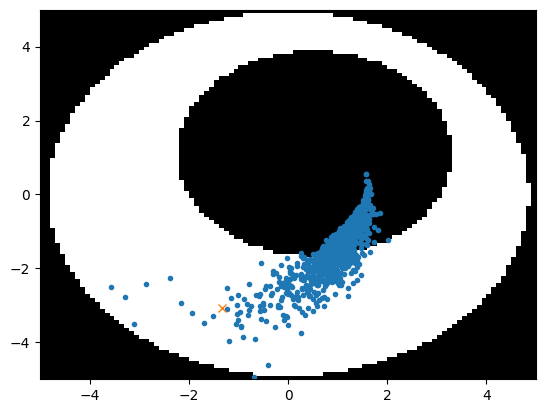

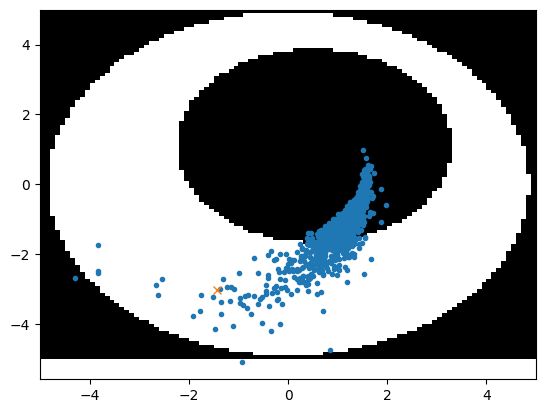

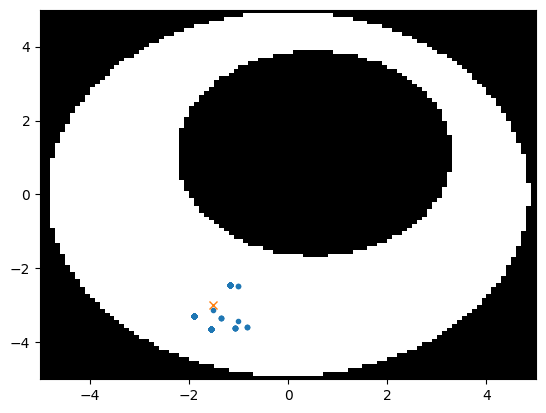

In [53]:
def run_monte_carlo_localization(env, robot_radius, robot_wheel_spacing, action, num_particles, dt, sigma_l, sigma_r, sigma_lidar, lidar_freq):

    # environment will simulate wheel speed sensor and lidar sensor
    env.unwrapped.sensor_models = {
        "wheel_speeds": sensor_models.WheelSpeedSensor(
            r=robot_radius, w=robot_wheel_spacing
        ),
        "lidar": sensor_models.Lidar2D(env.unwrapped.map),
    }
    env.unwrapped.dt = dt

    # initialize the robot in a specific state to make experiments repeatable
    np.random.seed(0)
    obs, _ = env.reset()
    env.unwrapped.state = np.array([0.5, -3.5, np.pi])
    # env.unwrapped.state = np.array([-3.2, 0.0, np.pi / 2])
    env.unwrapped.action = action
    obs = env.unwrapped._get_obs()  # pylint:disable=protected-access

    localizer = MCL(
        dt=dt,
        num_particles=num_particles,
        r=robot_radius,
        w=robot_wheel_spacing,
        sigma_l=sigma_l,
        sigma_r=sigma_r,
        sigma_lidar=sigma_lidar,
        map=env.unwrapped.map,
    )

    # draw map and overlay intial particle positions
    ax = env.unwrapped.map.draw_map(show=False)
    ax.plot(
        localizer.particles[:, 0, 2], localizer.particles[:, 1, 2], "."
    )
    ax.plot(env.unwrapped.state[0], env.unwrapped.state[1], "x")
    plt.show()

    localizer.update(obs["lidar"])
    for t in np.arange(start=0, stop=2.1, step=dt):
        obs, _, _, _, _ = env.step(action)

        # every dt seconds, propagate particles using wheel speeds
        localizer.propagate(obs["wheel_speeds"])

        # every lidar_freq seconds, update particles using lidar reading
        if (t % lidar_freq < 0.01 or t % lidar_freq > lidar_freq - 0.01) and t > 0:
            localizer.update(obs["lidar"])

        # draw map and overlay intial particle positions
        ax = env.unwrapped.map.draw_map(show=False)
        ax.plot(
            localizer.particles[:, 0, 2], localizer.particles[:, 1, 2], "."
        )

        # plot true state - just for visualization, shouldn't use this info in your estimator ;)
        ax.plot(env.unwrapped.state[0], env.unwrapped.state[1], "x")
        plt.show()

env = gymnasium.make("gym_neu_racing/NEURacing-v0")
robot_radius = 0.25
robot_wheel_spacing = 0.5
action = np.array([1.0, -0.25])
num_particles = 1000
dt = 0.1
sigma_l = 0.5
sigma_r = 0.5
sigma_lidar = 1.0
lidar_freq = 1.0
run_monte_carlo_localization(env, robot_radius, robot_wheel_spacing, action, num_particles, dt, sigma_l, sigma_r, sigma_lidar, lidar_freq)

# Problem 2: Mapping (estimating map given known robot pose)

In lecture, we saw that we can keep track of the log-odds occupancy for each cell in a map, rather than the probability. This is because log-odds encodes the same information but enables us to use addition instead of multiplication in combining various terms. But, it's often more intuitive to define thresholds in probability values and return the estimated occupancy map using probabilities. To make this easy, we provide you with these methods that you're welcome to use in your implementation.

In [ ]:
def log_odds_to_prob(log_odds: np.ndarray) -> np.ndarray:
    return 1 - 1 / (1 + np.exp(log_odds))

def prob_to_log_odds(prob: np.ndarray) -> np.ndarray:
    return np.log(prob / (1 - prob))

## 2a) Mapping Algorithm

In this problem, you're given the robot's states and lidar readings and need to build an occupancy grid that captures your current estimate of the true environment map (which we'll assume is unavailable here, even though the simulator uses it to generate lidar measurements).

We provide the structure of a `Mapper` class for you. Your main job is to implement the `step` method to update `self.log_odds_map`. The class is set up so calling `Mapper().probability_map` will automatically return an array with the probability of occupancy for each cell, based on that instance's current `self.map.log_odds_map` - we used Python properties to link these two variables automatically.

As a rough sketch of how the `step` method could work (feel free to try other ways):
- get the (x,y) coordinates of each lidar "hit point" and transform these into the world frame using `obs["state"]` (you may want to ignore/handle lidar readings that go outside the map's boundaries or have the lidar's max range)
- use `self.map.world_coordinates_to_map_indices(hit_pts_in_world_frame)` to get the map indices corresponding to those world frame coordinates
- move along the cells between the robot and the lidar hit cell to "clear" cells up to the hit point, then "fill" the hit point. More specifically, since we're  making a probabilistic estimate of each cell's probability, you should update the `self.map.log_odds_map` using `self.log_odds_free`, `self.log_odds_occ`, and `self.log_odds_prior` as appropriate.

**Deliverables**:
- Implement `Mapper`, in particular the `step` method, to take in an `obs` containing the robot's state (in the world frame) and a lidar reading (`obs["state"]` and `obs["lidar"]`), and update `self.map.log_odds_map`.
- What happens if you replace the lidar sensor that the simulator uses with `sensor_models.Lidar2DGaussian(env.unwrapped.map, range_variance=...)` ? Show us a couple maps for different values for different values of `range_variance`. How could you compensate for this lidar noise with your `Mapper`?

In [43]:
class Mapper:
    def __init__(
        self, p_free: float = 0.2, p_occ: float = 0.8, p_prior: float = 0.5
    ):
        self.map = Map(x_width=10, y_width=10, grid_cell_size=0.1)

        # feel free to change the default values for p_free, p_occ, p_prior!
        self.p_free = p_free
        self.p_occ = p_occ
        self.p_prior = p_prior
        self.log_odds_free = prob_to_log_odds(p_free)
        self.log_odds_occ = prob_to_log_odds(p_occ)
        self.log_odds_prior = prob_to_log_odds(p_prior)

        # initialize with P(occ) = 0.5 for all cells (unknown) -- feel free to change this!
        self.map.log_odds_map = np.zeros(
            self.map.static_map.shape, dtype=float
        )

    # If someone calls Mapper().probability_map, this method will run and convert
    # the current `self.map.log_odds_map` to an array of probabilities per cell.
    # You don't need to explicitly store `self.probability_map` and can just keep
    # `self.log_odds_map` updated ("properties" are a useful Python concept).
    @property
    def probability_map(self):
        return log_odds_to_prob(self.map.log_odds_map)

    def step(self, obs):
        """Using current state & lidar, update esimated gridmap log-odds."""

        # update self.map.log_odds_map here!
        # raise NotImpelementedError
        ranges = obs["lidar"]["ranges"]
        non_max_range_inds = np.where(ranges < np.inf)
        ranges = ranges[non_max_range_inds]
        angles = obs["lidar"]["angles"][non_max_range_inds]
        hit_pts_in_lidar_frame = np.stack(
            [ranges * np.cos(angles), ranges * np.sin(angles)]
        ).T


        x, y, theta = obs["state"]
        T_world_lidar = np.array(
            [
                [np.cos(theta), -np.sin(theta), x],
                [np.sin(theta), np.cos(theta), y],
                [0, 0, 1],
            ]
        )


        hit_pts_in_lidar_frame_homogeneous = np.hstack(
            [hit_pts_in_lidar_frame, np.ones((hit_pts_in_lidar_frame.shape[0], 1))]
        )
        hit_pts_in_world_frame = np.dot(
            hit_pts_in_lidar_frame_homogeneous, T_world_lidar.T
        )

        print(hit_pts_in_world_frame)
        for pt in hit_pts_in_world_frame:
            plt.plot([x, pt[0]], [y, pt[1]], "r-")

        estimated_map = self.probability_map.copy()

        return estimated_map

You can debug your mapping algorithm with the following code, or any other way you design. You should increase `num_timesteps` so you can build a complete map of the environment, but keeping it small at first may help in debugging. You are also welcome to try having the system take different actions, but the code below is defined in a way where the robot should be able to do a full lap around the track.

In [44]:
env = gymnasium.make("gym_neu_racing/NEURacing-v0")
env = MappingWrapper(env)

# Initialize the environment (and set random seed so any randomness is repeatable)
np.random.seed(0)

# Tell the environment to use your new Lidar2D sensor
env.unwrapped.sensor_models = {
    "state": sensor_models.StateFeedback(),
    "lidar": sensor_models.Lidar2D(env.unwrapped.map),
}

# Reset the environment and get the first observation (state + lidar)
obs, _ = env.reset()

# initialize the robot in a particular state (feel free to start from different places when testing your algorithm)
env.unwrapped.state = np.array([0.5, -3.5, np.pi])
obs["state"] = env.unwrapped.state
obs["lidar"] = env.unwrapped.sensor_models["lidar"].step(obs["state"], None)

mapper = Mapper()

states = []

# run the simulator & mapper for num_timesteps to build a complete map of the environment
num_timsteps = 5
for _ in range(num_timsteps):
    estimated_map = mapper.step(obs)
    action = np.array([1.0, -0.25])
    obs, _, _, _, _ = env.step(action)

    # keep track of the current state, just for visualization later
    states.append(obs["state"])

# draw your best guess of the environment map along with your robot's trajectory
mapper.map.static_map = estimated_map.copy()
mapper.map.draw_map(show=False)
plt.plot([state[0] for state in states], [state[1] for state in states], "x")
plt.show()

NameError: name 'prob_to_log_odds' is not defined